# Isotonic Regression

## Authors:
Iuliana Ilie <br>
Benjamin Vega

In [1]:
from pyspark.ml.regression import IsotonicRegression
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
import numpy as np
import matplotlib.pyplot as plt

## Load dataset

### Create Spark session and load dataset

In [2]:
spark_session = SparkSession\
        .builder\
        .appName("Spark Regression")\
        .getOrCreate()
dataset = spark_session\
        .read\
        .format("libsvm")\
        .load("data_file_AAPL.txt")


In [3]:
dataset.printSchema()
dataset.show()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)

+----------+--------------------+
|     label|            features|
+----------+--------------------+
|115.970001|(10,[0,1,2,3,4,5,...|
|    116.32|(10,[0,1,2,3,4,5,...|
|118.690002|(10,[0,1,2,3,4,5,...|
|119.029999|(10,[0,1,2,3,4,5,...|
|114.949997|(10,[0,1,2,3,4,5,...|
|110.440002|(10,[0,1,2,3,4,5,...|
|108.769997|(10,[0,1,2,3,4,5,...|
|108.860001|(10,[0,1,2,3,4,5,...|
|    115.32|(10,[0,1,2,3,4,5,...|
|111.199997|(10,[0,1,2,3,4,5,...|
|116.599998|(10,[0,1,2,3,4,5,...|
|115.050003|(10,[0,1,2,3,4,5,...|
|115.040001|(10,[0,1,2,3,4,5,...|
|    115.75|(10,[0,1,2,3,4,5,...|
|116.870003|(10,[0,1,2,3,4,5,...|
|117.510002|(10,[0,1,2,3,4,5,...|
|115.980003|(10,[0,1,2,3,4,5,...|
|119.019997|(10,[0,1,2,3,4,5,...|
|120.709999|(10,[0,1,2,3,4,5,...|
|121.190002|(10,[0,1,2,3,4,5,...|
+----------+--------------------+
only showing top 20 rows



## Algorithm Implementation

In [4]:
ir = IsotonicRegression(featuresCol = 'features', labelCol = 'label')

### Train-test split

In [5]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = dataset.randomSplit([0.7, 0.3])
print(trainingData.select("label").show(20))

+--------+
|   label|
+--------+
|0.117188|
|0.117188|
|0.117746|
|0.117746|
|0.118304|
| 0.12221|
| 0.12221|
| 0.12221|
|0.124442|
|0.126116|
|0.127232|
|0.130022|
|0.131138|
|0.131138|
|0.131696|
|0.135603|
|0.136161|
|0.136161|
|0.136719|
|0.137277|
+--------+
only showing top 20 rows

None


### Model train

In [6]:
train_model = ir.fit(trainingData)

### Make predictions

In [7]:
predictions = train_model.transform(testData)

## Plot prediction

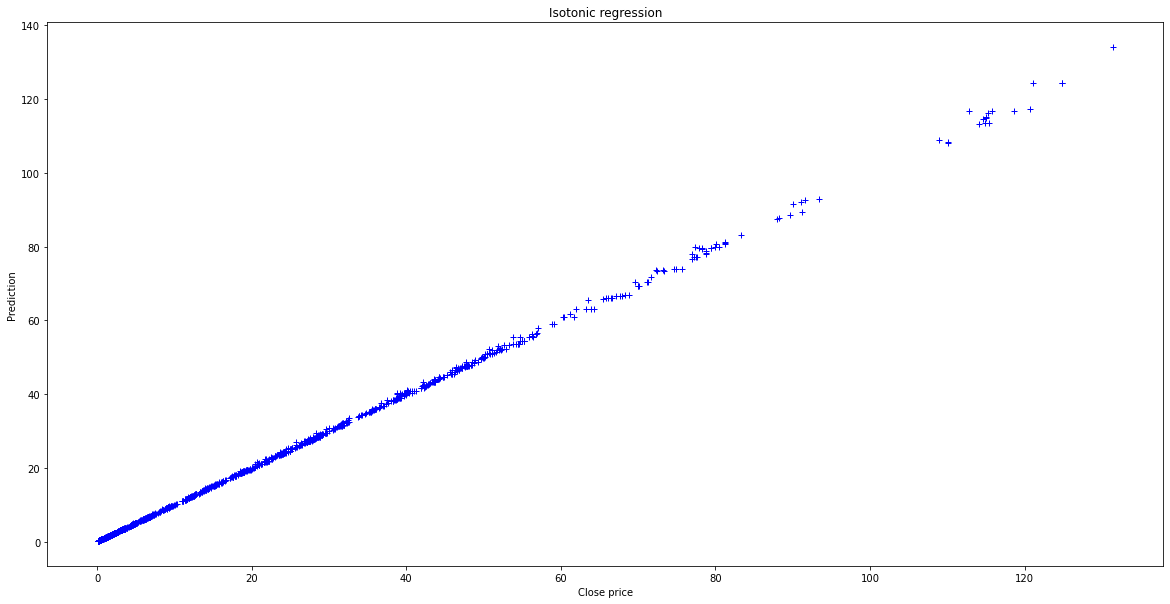

0.27964807424746824


In [8]:
# Create evaluator to evaluate the prediction results
evaluator= RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

# Compute RMSE
rmse = evaluator.evaluate(predictions)

rfResult = predictions.toPandas()
plt.figure(figsize=(20,10))

# plot predicted values 
plt.plot(rfResult.label, rfResult.prediction, 'b+')
plt.xlabel('Close price')
plt.ylabel('Prediction')
plt.title("Isotonic regression")
plt.show()

print(rmse)

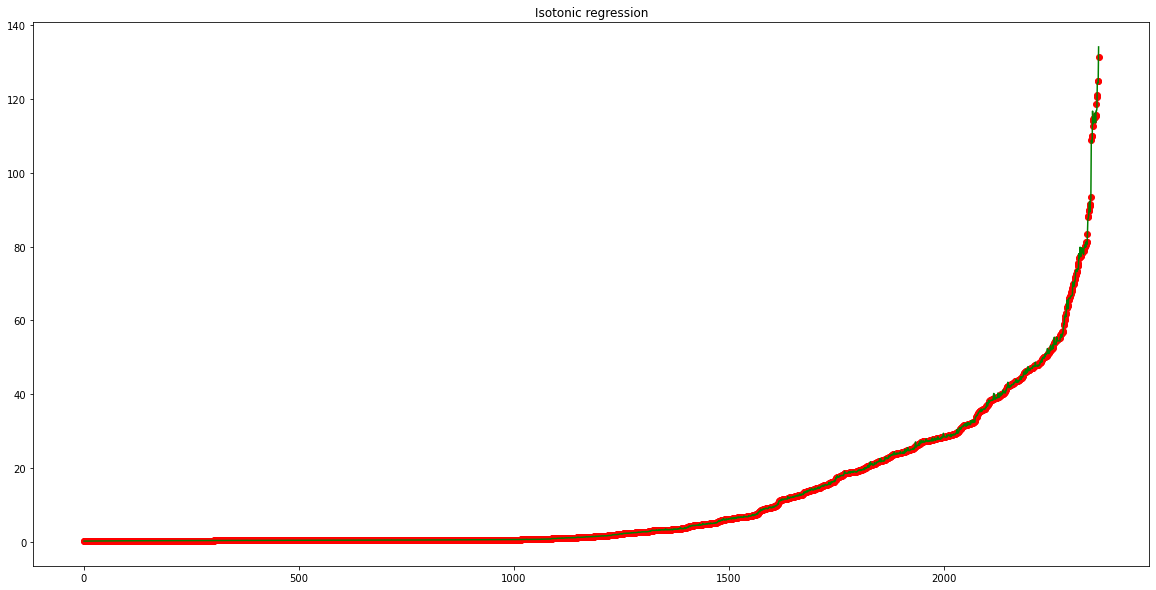

Model RMSE 0.27964807424746824


In [9]:
# Create x axis values
nr = range(rfResult.label.count())
plt.figure(figsize=(20,10))

# Plot labels and predicted values
plt.scatter(nr, rfResult.label, color = "red")
plt.plot(nr, rfResult.prediction, color = "green")
plt.title("Isotonic regression")

plt.show()
print("Model RMSE", rmse)

## Find the best model by implementing Cross-Validation

We prepared ParamGridBuilder, builder for a param grid used in grid search-based model selection and find the best configuration. <br>
isotonic - whether the output sequence should be isotonic/increasing (true) or an isotonic/decreasing (false).

In [10]:
# create grid of parameters 
paramGrid = ParamGridBuilder() \
    .addGrid(ir.isotonic, [x for x in [True,False]]) \
    .build()

### Create evaluator

In [11]:
# Create evaluator to evaluate the prediction results
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
    

### Use cross-validation

estimator: algorithm or Pipeline to tune <br>
estimatorParamMaps: parameters to choose from, sometimes called a “parameter grid” to search over<br>
evaluator: metric to measure how well a fitted Model does on held-out test data

In [12]:
crossval = CrossValidator(estimator=ir,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

## Train the algorithm and predict the test labels

In [13]:
cvModel_new = crossval.fit(trainingData)

#prediction
predictions_new = cvModel_new.transform(testData)

#Calculate RMSE
rmse_new = evaluator.evaluate(predictions_new)
    
#Get Best model
bestModel = cvModel_new.bestModel

## Plot the fine tuned data

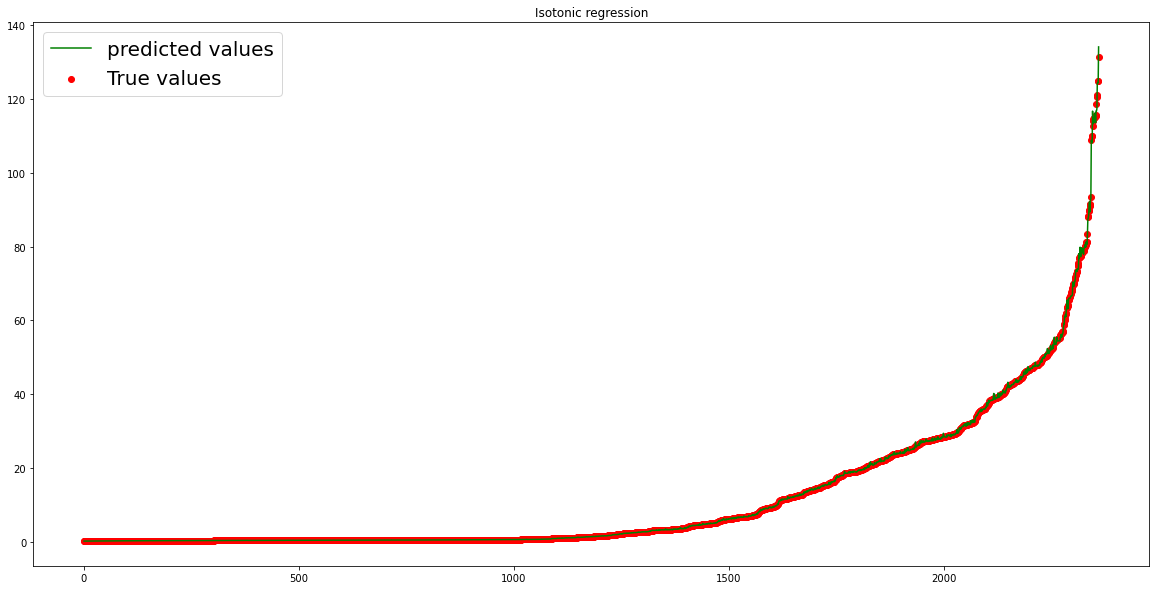

Model RMSE 0.27964807424746824


In [14]:
rfResult_new = predictions_new.toPandas()
nr = range(rfResult_new.label.count())

plt.figure(figsize=(20,10))

# Plot labels and predicted values
plt.scatter(nr, rfResult_new.label, color = "red", label="True values")
plt.plot(nr, rfResult_new.prediction, color = "green", label="predicted values")
plt.title("Isotonic regression")
plt.legend(prop={'size': 20})
plt.show()
print("Model RMSE", rmse_new)